In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pandas as pd
import healpy as hp
import time
import warnings
from pixell import reproject
from classy import Class
%matplotlib inline
import s1 
import pysm3 
import ST

NameError: name 'r' is not defined

In [ ]:
from pixell import enmap, utils

In [ ]:
#Gabor filter

def gabor_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Gabor filter.
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        freq : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        offset : int, optional
            offset by which the signal starts
        Returns
        -------
        gabor_2d : ndarray
            numpy array of size (M, N)
    """
    gab = np.zeros((M, N), np.complex64)
    [x, y] = np.mgrid[-1*(M//2):(M//2),-1*(N//2):(N//2)]
    #print ()
    arg = -(x**2+y**2)/(2*sigma*sigma) + 1.j * freq*np.sqrt(x**2+y**2)
    #print (arg.shape)
    gab += np.exp(arg)

    norm_factor = (2 * np.pi * sigma * sigma)
    gab /= norm_factor

    return gab

In [ ]:
def morlet_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Morlet filter.
        A Morlet filter is the sum of a Gabor filter and a low-pass filter
        to ensure that the sum has exactly zero mean in the temporal domain.
        It is defined by the following formula in space:
        psi(u) = g_{sigma}(u) (e^(i xi^T u) - beta)
        where g_{sigma} is a Gaussian envelope, xi is a frequency and beta is
        the cancelling parameter.
        Parameters
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        xi : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        Returns
        -------
        morlet_2d : ndarray
            numpy array of size (M, N)
    """
    wv = gabor_2d(M, N, sigma,  freq)
    wv_modulus = gabor_2d(M, N, sigma, 0)
    K = np.sum(wv) / np.sum(wv_modulus)

    mor = wv - K * wv_modulus
    return mor

Scattering transform

In [2]:
#S1 coefficients

def s1s2coeff(x,J):
    
    s1=np.zeros(J)
    s2=np.zeros((J,J))
    M=x.shape[0]
    N=x.shape[1]
    for j1 in range(J):
        
        sigma1=0.8*2**j1
        freq1=(3*np.pi)/(4.*2**j1)
        
        mor1=morlet_2d(M, N, sigma1, freq1)
        phi1=gabor_2d(M,N,sigma1,0)
        mor1fft=np.real(np.fft.fft2(np.fft.fftshift(mor1)))
        phi1fft=np.real(np.fft.fft2(np.fft.fftshift(phi1)))
        
        U0=np.fft.fft2(x)
        U1=U0*mor1fft
        U1=np.fft.ifft2(U1)
        S1=np.abs(U1)
        #U1=np.fft.fft2(U1)
        #S1=U1*phi1fft
        #S1=np.abs(np.fft.ifft2(S1))
        #S1=S1.mean()
        s1[j1]=np.mean(S1)
        
        for j2 in range(J):
            
            sigma2=0.8*2**j2
            freq2=(3*np.pi)/(4.*2**j2)
            
            mor2=morlet_2d(M, N, sigma2, freq2)
            phi2=gabor_2d(M,N,sigma2,0)
            mor2fft=np.real(np.fft.fft2(np.fft.fftshift(mor2)))
            phi2fft=np.real(np.fft.fft2(np.fft.fftshift(phi2)))
            
            U2=S1*mor2fft
            U2=np.fft.ifft2(U2)
            S2=np.abs(U2)
            #U2=np.fft.fft2(U2)
            #S2=U2*phi2fft
            #S2=np.abs(np.fft.ifft2(S2))
            #S2=S2.mean()
            s2[j1][j2]=np.mean(S2)
            
    
    return s1,s2

In [2]:
nside_2048 = 2048
nside_1024 = 1024
nside_0256 = 256

In [20]:
res2048_arcmin = hp.nside2resol(2048, arcmin=True)
res1024_arcmin = hp.nside2resol(1024, arcmin=True)
res512_arcmin = hp.nside2resol(512, arcmin=True)
res256_arcmin = hp.nside2resol(256, arcmin=True)
print(res2048_arcmin)
print(res1024_arcmin)
print(res512_arcmin)
print(res256_arcmin)

1.717743205908703
3.435486411817406
6.870972823634812
13.741945647269624


In [3]:
lmax_0256 = 3*nside_0256 -1 
lmax_1024 = 3*nside_1024 -1 
lmax_2048 = 3*nside_2048 -1 

In [4]:
ell_0256 = np.arange(0,lmax_0256+1)
ellsc_0256 = 21600/ell_0256
norm_0256 = ell_0256 * (ell_0256+1) / (2*np.pi)

<ipython-input-4-021124972f74>:2: RuntimeWarning: divide by zero encountered in true_divide
  ellsc_0256 = 21600/ell_0256


In [5]:
ell_1024 = np.arange(0,lmax_1024+1)
ellsc_1024 = 21600/ell_1024
norm_1024 = ell_1024 * (ell_1024+1) / (2*np.pi)

<ipython-input-5-d05932342f46>:2: RuntimeWarning: divide by zero encountered in true_divide
  ellsc_1024 = 21600/ell_1024


In [6]:
ell_2048 = np.arange(0,lmax_2048+1)
ellsc_2048 = 21600/ell_2048
norm_2048 = ell_2048 * (ell_2048+1) / (2*np.pi)

<ipython-input-6-3509b796c297>:2: RuntimeWarning: divide by zero encountered in true_divide
  ellsc_2048 = 21600/ell_2048


In [7]:
dl_test_1024 = ell_1024**2 / (1e8 + ell_1024**4) * 2e10

cl_test_1024 = dl_test_1024/ norm_1024
cl_test_1024[0] = 0

<ipython-input-7-380bc72156fd>:3: RuntimeWarning: invalid value encountered in true_divide
  cl_test_1024 = dl_test_1024/ norm_1024


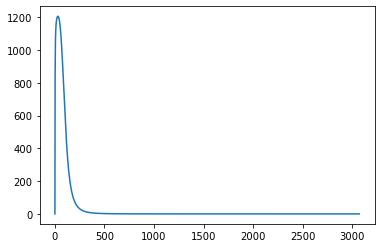

In [8]:
plt.plot (ell_1024 , cl_test_1024)

Text(0, 0.5, 'Dl')

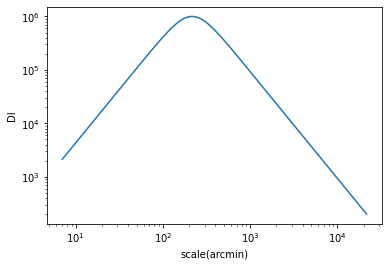

In [9]:
plt.loglog (ellsc_1024 , dl_test_1024)
plt.xlabel("scale(arcmin)")
plt.ylabel("Dl")

In [10]:
map_test_1024 = hp.synfast (cl_test_1024 , nside_1024)

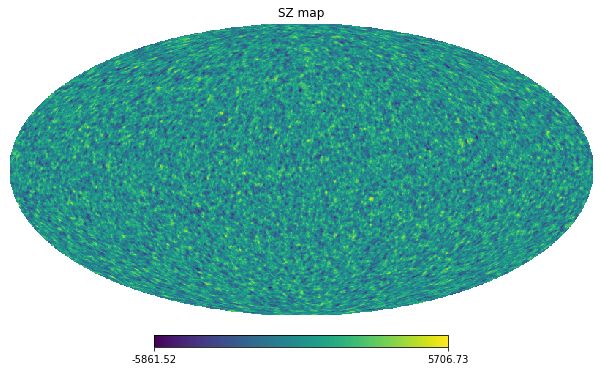

In [11]:
hp.mollview(map_test_1024 ,title="SZ map")

In [12]:
alm_test = hp.map2alm (map_test_1024)
almsize = alm_test.shape[0]
mapsize = map_test_1024.shape[0]

In [71]:
N = 7
#imgsize_deg = 10  # in degrees
#imgsize_arcmin = imgsize_deg * 60  # in arcmin
#pixsize_1024 = int(np.ceil(imgsize_arcmin / res1024_arcmin))
#imgsize_arcmin = pixsize_1024 * res1024_arcmin
pix_number = 2**N
imgsize_arcmin = pix_number*res1024_arcmin
imgsize_deg = imgsize_arcmin /60
box = np.array([[-imgsize_arcmin//2, imgsize_arcmin//2], [imgsize_arcmin//2, -imgsize_arcmin//2]]) * utils.arcmin
shape256, wcs256 = enmap.geometry(pos=box, res=res256_arcmin*utils.arcmin, proj='car')
shape512, wcs512 = enmap.geometry(pos=box, res=res512_arcmin*utils.arcmin, proj='car')
shape1024, wcs1024 = enmap.geometry(pos=box, res=res1024_arcmin*utils.arcmin, proj='car')
imap256  = enmap.zeros((3,) + shape256,  wcs=wcs256)
imap512  = enmap.zeros((3,) + shape512,  wcs=wcs512)
imap1024 = enmap.zeros((3,) + shape1024, wcs=wcs1024)

In [72]:
fmap_test_1024 = reproject.enmap_from_healpix(map_test_1024, shape=(pix_number , pix_number), wcs=imap1024.wcs)


Preparing SHT
T -> alm
float64 complex128
Computing pixel positions
Computing rotated positions
Projecting


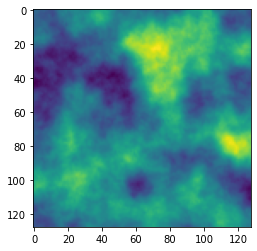

In [73]:
plt.imshow(fmap_test_1024[0])


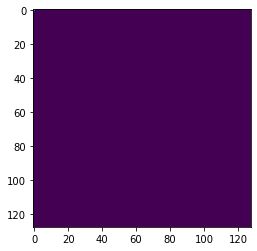

In [74]:
map_delta = np.zeros ((2**N,2** N))
map_delta[0,0] =1
plt.imshow(map_delta)

In [75]:
jmax = N
print (jmax)

7


In [76]:
pix_size = res1024_arcmin

In [77]:
S1_test , S2_test = s1s2coeff(fmap_test_1024[0] , jmax)

In [78]:
S1_delta , S2_delta = s1s2coeff(map_delta , jmax)

In [79]:
S0_test = (pix_size*np.pi/180/60)**2 * np.sum (fmap_test_1024)
S0_test

3.87265033965763

In [80]:
mu0 = (N*(pix_size*np.pi/180/60))**2

In [81]:
S0_normalized = S0_test/mu0
S0_normalized

79137.7141453851

In [82]:
I0sqrt = np.sum (fmap_test_1024**2 * (pix_size*np.pi/180/60)**2) /((mu0)**2)
print (I0sqrt)

13958158707059.844


In [83]:
S1_normalized = S1_test / S1_delta


array([ 488408.16648958,  810396.05853956, 1593997.06381966,
       3098068.39383869, 4908865.48202765, 5671600.19150252,
       4765006.91984246])

In [84]:
S2_normalized = S2_test/S2_delta


In [85]:
S2_sum = 0
for i in range (jmax):
    for j in range (i+1 , jmax):
        S2_sum+=S2_normalized[i,j]**2

In [86]:
S0_normalized**2+np.sum(S1_normalized**2)+S2_sum

127030393133465.44